In [1]:
import numpy as np
from functools import partial
import ipywidgets as widgets
from IPython.display import display
from pydrake.geometry.optimization import IrisOptions, HPolyhedron, Hyperellipsoid
from pydrake.solvers import MosekSolver, CommonSolverOption, SolverOptions
from pydrake.all import (PiecewisePolynomial, 
                         InverseKinematics, 
                         Sphere, 
                         Rgba, 
                         RigidTransform, 
                         RotationMatrix, 
                         Solve,
                         MathematicalProgram,
                         RollPitchYaw,
                         Cylinder)
import time
import pydrake
from environments import get_environment_builder

plant_builder = get_environment_builder('7DOF4SHELVES')
plant, scene_graph, diagram, diagram_context, plant_context, meshcat = plant_builder(usemeshcat=True)

scene_graph_context = scene_graph.GetMyMutableContextFromRoot(
    diagram_context)

INFO:drake:Meshcat listening for connections at http://localhost:7000


In [2]:
def show_pose(qvis, plant, plant_context, diagram, diagram_context, endeff_frame, show_body_frame = None):
    plant.SetPositions(plant_context, qvis)
    diagram.ForcedPublish(diagram_context)
    tf =plant.EvalBodyPoseInWorld(plant_context,  plant.GetBodyByName(endeff_frame))
    transl = tf.translation()+tf.rotation()@np.array([0,0.1,0])
    if show_body_frame is not None:
        show_body_frame(RigidTransform(tf.rotation(), transl))

def show_ik_target(pose, meshcat, name):
    h = 0.2
    if 'targ' in name:
        colors = [Rgba(1,0.5,0, 0.5), Rgba(0.5,1,0, 0.5), Rgba(0.0,0.5,1, 0.5)]
    else:
        colors = [Rgba(1,0,0, 1), Rgba(0.,1,0, 1), Rgba(0.0,0.0,1, 1)]

    rot = pose.rotation()@RotationMatrix.MakeYRotation(np.pi/2)
    pos= pose.translation() +pose.rotation()@np.array([h/2, 0,0])
    meshcat.SetObject(f"/drake/ik_target{name}/triad1",
                                   Cylinder(0.01,0.2),
                                   colors[0])
    meshcat.SetTransform(f"/drake/ik_target{name}/triad1",RigidTransform(rot, pos))
    rot = pose.rotation()@RotationMatrix.MakeXRotation(-np.pi/2)
    pos= pose.translation() +pose.rotation()@np.array([0,h/2,0])

    meshcat.SetObject(f"/drake/ik_target{name}/triad2",
                                   Cylinder(0.01,0.2),
                                   colors[1])
    meshcat.SetTransform(f"/drake/ik_target{name}/triad2",RigidTransform(rot, pos))
    pos= pose.translation().copy()
    rot = pose.rotation()
    pos = pos + rot@np.array([0,0,h/2])
    meshcat.SetObject(f"/drake/ik_target{name}/triad3",
                                   Cylinder(0.01,0.2),
                                   colors[2])
    meshcat.SetTransform(f"/drake/ik_target{name}/triad3",RigidTransform(rot, pos))
from visualization_utils import get_shunk_plotter

plot_endeff_poses = get_shunk_plotter(plant, scene_graph, plant_context, diagram_context)

{'body': <GeometryId value=69>, 'left_finger': <GeometryId value=75>, 'right_finger': <GeometryId value=81>}


/home/peter/.local/lib/python3.8/site-packages/scipy/__init__.py:143: UserWarning: A NumPy version >=1.19.5 and <1.27.0 is required for this version of SciPy (detected version 1.17.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
show_body_frame = partial(show_ik_target, 
                          meshcat=meshcat, 
                          name='endeff_actual', 
                          )
showres = partial(show_pose, 
                  plant = plant, 
                  plant_context = plant_context, 
                  diagram = diagram, 
                  diagram_context = diagram_context,
                  endeff_frame = 'body',
                  show_body_frame=show_body_frame)

In [4]:
q_meshcat = np.zeros(plant.num_positions())

sliders = []
for i in range(plant.num_positions()):
    q_low = plant.GetPositionLowerLimits()[i]
    q_high = plant.GetPositionUpperLimits()[i]
    sliders.append(widgets.FloatSlider(min=q_low, max=q_high, value=0, description=f"q{i}"))

def handle_slider_change(change, idx):
    q_meshcat[idx] = change['new']
    showres(q_meshcat)
    
idx = 0
for slider in sliders:
    slider.observe(partial(handle_slider_change, idx = idx), names='value')
    idx+=1

for slider in sliders:
    display(slider)

FloatSlider(value=0.0, description='q0', max=2.96706, min=-2.96706)

FloatSlider(value=0.0, description='q1', max=2.0944, min=-2.0944)

FloatSlider(value=0.0, description='q2', max=2.96706, min=-2.96706)

FloatSlider(value=0.0, description='q3', max=2.0944, min=-2.0944)

FloatSlider(value=0.0, description='q4', max=2.96706, min=-2.96706)

FloatSlider(value=0.0, description='q5', max=2.0944, min=-2.0944)

FloatSlider(value=0.0, description='q6', max=3.05433, min=-3.05433)

In [5]:
from visualization_utils import plot_points, plot_regions
from pydrake.all import VPolytope, Role
from task_space_seeding_utils import (get_cvx_hulls_of_bodies,
                                      get_AABB_cvxhull,
                                      task_space_sampler_mp,
                                      task_space_sampler)

In [6]:
def densify_waypoints(waypoints_q, densify = 200):
    dists = []
    dense_waypoints = []
    for idx in range(len(waypoints_q[:-1])):
        a = waypoints_q[idx]
        b = waypoints_q[idx+1]
        t = np.linspace(1,0, 10)
        locs_endeff = []
        dists_endeff = []
        for tval in t:
            a = a*tval + b*(1-tval)
            qa = a#Ratfk.ComputeQValue(ta, np.zeros(7))
            #showres(qa)
            #time.sleep(0.1)            
            plant.SetPositions(plant_context, qa)
            tf_tot= plant.EvalBodyPoseInWorld(plant_context, plant.GetBodyByName('body'))
            tf = tf_tot.translation() + tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.13
            locs_endeff.append(tf)
        for i in range(len(locs_endeff)-1):
            dists_endeff.append(np.linalg.norm(locs_endeff[i]- locs_endeff[i+1]))
        d = np.sum(dists_endeff)
        #print(d * densify)
        t = np.linspace(1,0,int(densify*d))
        for tval in t:
            dense_waypoints.append(waypoints_q[idx]*tval + waypoints_q[idx+1]*(1-tval))
    return dense_waypoints

def plot_endeff_traj(dense_waypoints, name = '', color= (1,0,0,1)):
    color = Rgba(color[0], color[1], color[2], color[3])
    start_idx = 0
    for i, qa in enumerate(dense_waypoints):
        #qa = Ratfk.ComputeQValue(ta, np.zeros(7))
        #showres(qa)
        #time.sleep(0.1)            
        plant.SetPositions(plant_context, qa)
        tf_tot= plant.EvalBodyPoseInWorld(plant_context, plant.GetBodyByName('body'))
        tf = tf_tot.translation() + tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.13

        meshcat.SetObject(f"/iris/points/traj/{name}/{i+start_idx}",
                               Sphere(0.01),
                               color)

        meshcat.SetTransform(f"/iris/points/traj/{name}/{i+start_idx}",
                                   RigidTransform(RotationMatrix(),
                                                  tf))

In [7]:
#Samplers for testing coverage
from visibility_utils import generate_distinct_colors
offset_size = -0.00
geom_names = ['shelves_body']*4
              
model_names = ['shelves1', 
               'shelves2',
               'shelves3',
               'shelves4'
               ]
default_pos = [
        np.array([-1.76706,  0.9056 ,  0.     , -0.8944 ,  1.43294,  1.6056 ,
        0.     ]),
        np.array([ 1.73294,  0.9056 , -0.06706, -0.7944 ,  1.63294, -1.5944 ,
        0.     ]),
        np.array([-1.36706,  0.9056 ,  0.     , -0.8944 ,  1.43294, -1.3944 ,
        0.     ]),
        np.array([ 1.43294,  0.8056 , -0.06706, -0.7944 ,  1.63294,  1.6056 ,
        0.     ])]
approach_dir = [0, 
                0, 
                0,
                0] 
approach_sign = [1,-1,1,-1]
ts_samplers = []
cols = generate_distinct_colors(2*len(model_names), rgb = True)[1:]
#cols = [list(c)+[1] for c in cols]
AABB_sampling_regions = []
for i, (g, m) in enumerate(zip(geom_names, model_names)):
    cvx_hulls_of_ROI_unsc, bodies = get_cvx_hulls_of_bodies([g], [m], plant, scene_graph, scene_graph_context, scaling = 1.0)
    verts = [VPolytope(c).vertices().T for c in cvx_hulls_of_ROI_unsc]
    cvx_hulls_of_ROI = cvx_hulls_of_ROI_unsc
    cvx_hulls_of_ROI = []
    for v in verts:
        offset = approach_sign[i]*(np.sign(v[:,approach_dir[i]] - np.mean(v[:,approach_dir[i]]))==approach_sign[i])*offset_size
        v[:,approach_dir[i]] += offset #scale*(v[:,approach_dir[i]] - np.mean(v[:,approach_dir[i]])) +  np.mean(v[:,approach_dir[i]])
        cvx_hulls_of_ROI.append(HPolyhedron(VPolytope(v.T)))
    ts_min, ts_max, cvxh_hpoly = get_AABB_cvxhull(cvx_hulls_of_ROI)
    AABB_sampling_regions.append([ts_min, ts_max])
    plot_regions(meshcat, cvx_hulls_of_ROI, region_suffix=m,opacity=0.2, colors=[cols[i]])
    q0  = default_pos[i] #np.zeros(7)
    plant.SetPositions(plant_context, q0)
    plant.ForcedPublish(plant_context)
    showres(q0)
    t0 = plant.EvalBodyPoseInWorld(plant_context,  plant.GetBodyByName("body")).translation()       
    sample_handle_ts = partial(task_space_sampler_mp,
                            q0 = q0,
                            t0 = t0,
                            plant_builder = plant_builder,
                            frame_names = ['body'],
                            offsets = [np.array([0,0.1,0])],
                            cvx_hulls_of_ROI =cvx_hulls_of_ROI,
                            ts_min = ts_min,
                            ts_max = ts_max,
                            collision_free = True,
                            track_orientation = True,
                            axis_alignment = approach_dir[i]
                            )
    ts_samplers.append(sample_handle_ts)

In [8]:
from pydrake.all import SceneGraphCollisionChecker
from visibility_utils import vgraph
from clique_covers import compute_greedy_clique_partition

robot_instances = [plant.GetModelInstanceByName("iiwa"), plant.GetModelInstanceByName("wsg")]
checker = SceneGraphCollisionChecker(model = diagram,#.Clone(), 
                    robot_model_instances = robot_instances,
                    distance_function_weights =  [1] * plant.num_positions(),
                    #configuration_distance_function = _configuration_distance,
                    edge_step_size = 0.02)
vgraph_handle = partial(vgraph, checker = checker, parallelize = True) 

INFO:drake:Allocating contexts to support 20 parallel queries given omp_num_threads 20 omp_max_threads 20 and omp_thread_limit 2147483647 OpenMP enabled in build? true


In [9]:
import os
import pickle
Npts= 1000
if f"7dof_4shelves_test_samps{Npts}_{offset_size}.pkl" in os.listdir('tmp'):
    with open(f"tmp/7dof_4shelves_test_samps{Npts}_{offset_size}.pkl", 'rb') as f:
        d = pickle.load(f)
        q_obj = d['q_obj']
        t_obj = d['t_obj']
        ad_mat = d['ad_obj']
else:
    q_obj = []
    t_obj = []
    ad_obj = []
    for sh in ts_samplers:
        q, t, _, res = sh(Npts,[])
        ad_mat = vgraph_handle(q)
        q_obj +=[q]
        t_obj +=[t]
        ad_obj +=[ad_obj]
    with open(f"tmp/7dof_4shelves_test_samps{Npts}_{offset_size}.pkl", 'wb') as f:
        pickle.dump({'q_obj':q_obj, 't_obj':t_obj, 'ad_obj': ad_obj}, f)

In [10]:
meshcat.Delete('/shunk')
# for i in range(1,5):
#     meshcat.SetProperty(f"/iris/regionsshelves{i}", 'visible', False)

# plot_endeff_poses(meshcat, q_obj[0])

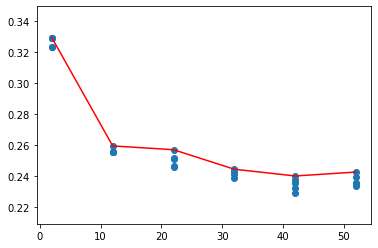

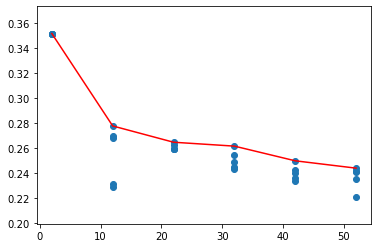

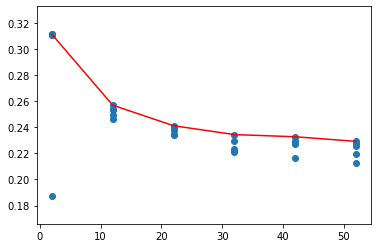

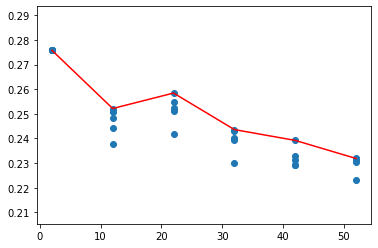

##### STATS ON CLUSTERS #####
cliques: 11
clusters: 2
mean cluster size: 500.0
mean clique size: 47.36363636363637
max clique size: 132
min clique size: 18
clique sizes: [132, 107, 69, 46, 31, 26, 21, 19, 18, 29, 23]
cliques: 11
clusters: 2
mean cluster size: 500.0
mean clique size: 45.54545454545455
max clique size: 106
min clique size: 20
clique sizes: [106, 105, 72, 38, 35, 30, 22, 21, 30, 22, 20]
cliques: 10
clusters: 2
mean cluster size: 500.0
mean clique size: 36.6
max clique size: 54
min clique size: 20
clique sizes: [54, 48, 41, 36, 33, 22, 20, 44, 44, 24]
cliques: 10
clusters: 2
mean cluster size: 500.0
mean clique size: 28.1
max clique size: 49
min clique size: 18
clique sizes: [49, 34, 31, 30, 28, 26, 23, 20, 22, 18]
num cliques: 42
num clusters: 8


In [15]:
min_clique_size= 18
kmeans_trials = 5
silhouette_method_steps = 10
#cluster points
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
cliques_obj = []
num_clusters_obj = []
cluster_sizes_obj = []
for i, (q, t) in enumerate(zip(q_obj, t_obj)):
    q_regularized = (q - np.mean(q, axis = 0))/np.std(q, axis = 0)
    sil = []
    kmsol = []
    min_k = 2#[5,5, 5]
    max_k = int(np.ceil(Npts/min_clique_size))#[20, 20, 100 ]
    clus_vals = np.arange(min_k, max_k, np.int(np.ceil(silhouette_method_steps)))
    clus_vals_trials = []
    mean_sil = []
    for k in clus_vals:
        #print(k)
        sil_loc = []
        for _ in range(kmeans_trials):
            km = KMeans(n_clusters=k).fit(q_regularized)
            kmsol.append(km)
            labels = km.labels_
            sil_score = silhouette_score(q_regularized, labels, metric='euclidean')
            sil.append(sil_score)
            sil_loc.append(sil_score)
            clus_vals_trials.append(k)
        mean_sil.append(np.max(sil_loc))
    fig = plt.figure()
    plt.scatter(clus_vals_trials,sil)
    plt.plot(clus_vals, mean_sil, c = 'r')
    plt.show(block = False)
    plt.pause(2)
    best_k = clus_vals[np.argmax(mean_sil)]
    best_clustering_idx = np.argmax(mean_sil[np.argmax(mean_sil)])
    best_clustering = kmsol[kmeans_trials*np.where(clus_vals == best_k)[0][0] + best_clustering_idx]
    num_clusters = best_k
    q_clus = [q[np.where(best_clustering.labels_ == l )[0], :] for l in range(num_clusters)]
    t_clus = [t[np.where(best_clustering.labels_ == l )[0], :] for l in range(num_clusters)]
    idx_clus = [np.where(best_clustering.labels_ == l )[0] for l in range(num_clusters)]
    clus_sizes = [len(qc) for qc in q_clus]
    cluster_sizes_obj.append(clus_sizes)
    num_clusters_obj.append(len(q_clus))
    vgraph_clus = [vgraph_handle(qc) for qc in q_clus]
    cliques_cluster = []
    for ad in vgraph_clus:
        smin = min_clique_size
        cliques = compute_greedy_clique_partition(ad.toarray(), min_cliuqe_size=smin)
        cl = []
        for c in cliques:
            if len(c)>=smin:
               cl.append(c)
        cliques_cluster.append(cl)
    cliques_clusters_glob = []
    for clus_idx, cliques in enumerate(cliques_cluster):
        for c in cliques:
            if len(c):
                cliques_clusters_glob.append(idx_clus[clus_idx][c])
    cliques_obj.append(cliques_clusters_glob)

print('#'*5 + " STATS ON CLUSTERS " + '#'*5 )
cliques = 0
clusters = 0
for i in range(len(cluster_sizes_obj)):
    print(f"cliques: {len(cliques_obj[i])}")
    print(f"clusters: { num_clusters_obj[i]}")
    print(f"mean cluster size: {np.mean(cluster_sizes_obj[i])}")
    print(f"mean clique size: {np.mean([len(c) for c in cliques_obj[i]])}")
    print(f"max clique size: {np.max([len(c) for c in cliques_obj[i]])}")
    print(f"min clique size: {np.min([len(c) for c in cliques_obj[i]])}")
    print(f"clique sizes: {[len(c) for c in cliques_obj[i]]}")
    cliques += len(cliques_obj[i])
    clusters += num_clusters_obj[i]

print(f"num cliques: {cliques}")
print(f"num clusters: {clusters}")
plt.show(block=False)
plt.pause(2)

In [17]:
t_tot = np.concatenate(tuple(t_obj), axis=0)
q_tot = np.concatenate(tuple(q_obj))
cliques_tot = []
offset = 0
for i, c in enumerate(cliques_obj):
    if i>0:
        offset+= len(q_obj[i-1])
    cliques_tot += [cl + offset for cl in c] 

In [11]:
from visibility_utils import get_col_func, get_sample_cfree_handle, get_coverage_estimator, vgraph
from region_generation import SNOPT_IRIS_ellipsoid_parallel
from clique_covers import get_iris_metrics

q_min = plant.GetPositionLowerLimits()*1
q_max =  plant.GetPositionUpperLimits()*1
col_func_handle_ = get_col_func(plant, plant_context)
sample_cfree = get_sample_cfree_handle(q_min,q_max, col_func_handle_)


In [12]:

require_sample_point_is_contained = True
iteration_limit = 1
configuration_space_margin = 1.e-3
termination_threshold = -1
num_collision_infeasible_samples = 100
relative_termination_threshold = 0.02
estimate_coverage = get_coverage_estimator(sample_cfree, pts = 3000)

snopt_iris_options = IrisOptions()
snopt_iris_options.require_sample_point_is_contained = require_sample_point_is_contained
snopt_iris_options.iteration_limit = iteration_limit
snopt_iris_options.configuration_space_margin = configuration_space_margin
#snopt_iris_options.max_faces_per_collision_pair = 60
snopt_iris_options.termination_threshold = termination_threshold
#snopt_iris_options.q_star = np.zeros(3)
snopt_iris_options.num_snopt_seed_guesses = 100
snopt_iris_options.num_collision_infeasible_samples = num_collision_infeasible_samples
snopt_iris_options.relative_termination_threshold = relative_termination_threshold
def col_hnd(pt):
    return 1- 1.0*checker.CheckConfigCollisionFree(pt)

iris_handle = partial(SNOPT_IRIS_ellipsoid_parallel,
                        region_obstacles = [],
                        logger = None, 
                        plant_builder = plant_builder,
                        snoptiris_options = snopt_iris_options,
                        estimate_coverage = estimate_coverage,
                        coverage_threshold = 1)

seed_points, metrics, _ = get_iris_metrics([q_tot[c] for c in cliques_tot], col_hnd)
seed = 0
if f"7dof_4shelves_regions_noapproachdir_{Npts}_{offset_size}_{seed}.pkl" in os.listdir('tmp'):
    with open(f"tmp/7dof_4shelves_regions_noapproachdir_{Npts}_{offset_size}_{seed}.pkl", 'rb') as f:
        d = pickle.load(f)
        regions_red = d['r']
        succs_sp = d['succs_sp']
        seed_points = d['sp']
        metrics = d['metrics']
else:
    regions_red, succs_sp, is_full = iris_handle(seed_points, metrics, [])
    with open(f"tmp/7dof_4shelves_regions_noapproachdir_{Npts}_{offset_size}_{seed}.pkl", 'wb') as f:
        pickle.dump({'r':regions_red, 'succs_sp':succs_sp, 'sp': seed_points, 'metrics': metrics}, f)

NameError: name 'cliques_tot' is not defined

In [13]:
from visibility_utils import check_visibility_to_regions
from utils import load_regions_from_experiment_dir

regions_c = load_regions_from_experiment_dir(
                    'logs/experiment_7dof_4shelves__0_1500_0.300greedy20231204110646', it = 3)

#7dof_bin_regions_noapproachdir_2000_0.05_1337
#7dof_bin_regions_2000_0.05_1337.pkl
with open(f"tmp/7dof_4shelves_regions_noapproachdir_1000_-0.0_0.pkl", 'rb') as f:
    d = pickle.load(f)
    regions_red = d['r']

Text(0.5, 1.0, 'connectivity')

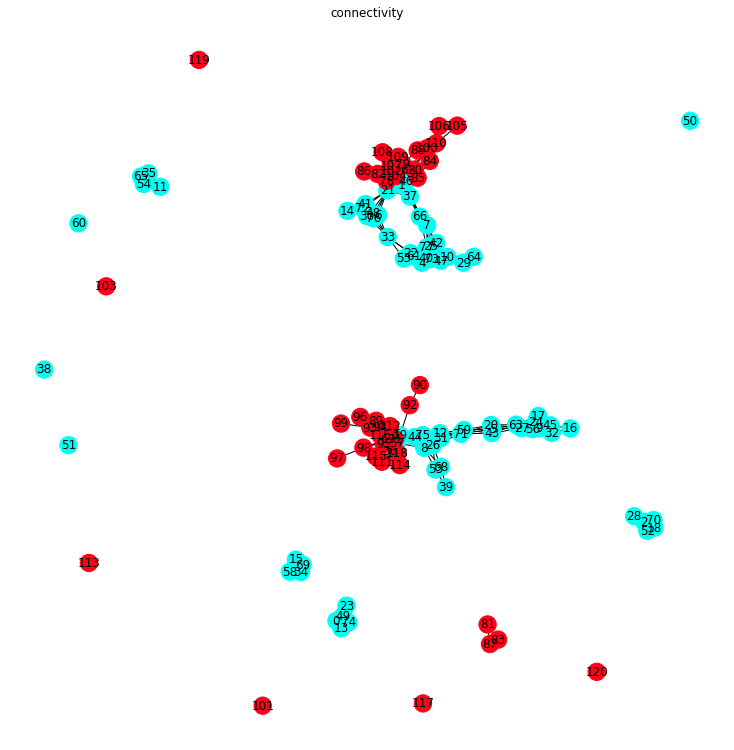

In [14]:
import networkx as nx
import matplotlib.pyplot as plt
from visibility_utils import generate_distinct_colors
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

regs =  regions_c +regions_red 
connectivity_graph = nx.Graph()
for idx in range(len(regs)):
    connectivity_graph.add_node(idx)

for idx1 in range(len(regs)):
    for idx2 in range(idx1 +1, len(regs)):
        r1 = regs[idx1]
        r2 = regs[idx2]
        if r1.IntersectsWith(r2):
            connectivity_graph.add_edge(idx1,idx2)

largest_con_comp = list(list(nx.connected_components(connectivity_graph))[0])
center_locations = np.array([r.ChebyshevCenter() for r in regs])

# tsne = TSNE(early_exaggeration=15, perplexity=80)
# X_tsne = tsne.fit_transform(center_locations)

fig = plt.figure(figsize=(10,10))

regions_connected_component = [regs[i] for i in largest_con_comp]
# plt.scatter(X_tsne[:len(regions_c),0], X_tsne[:len(regions_c),1], c = 'k')
# plt.scatter(X_tsne[len(regions_c):,0], X_tsne[len(regions_c):,1], c = 'r')
# nx.draw_networkx_edges(connectivity_graph, X_tsne)

hues = generate_distinct_colors(2+1)[1:]
colors = []
for g, h in zip([ regions_c, regions_red], hues):
    colors += [h]*len(g)

nx.draw_spring(connectivity_graph, 
                with_labels = True, 
                node_color = colors[:len(regs)])
plt.title(f"connectivity")

In [15]:
connector_samples, is_full = sample_cfree(200, 5000, [])

In [16]:
all_samps = np.concatenate((center_locations,connector_samples), axis = 0)
ad_vgraph = vgraph_handle(all_samps)

In [17]:
#remove clutter
adm = ad_vgraph.toarray()
adm[:len(center_locations), :len(center_locations)] = 0

In [18]:
offs =len(regions_red) +len(regions_c)
for i in range(len(connector_samples)):
    connectivity_graph.add_node(i + offs)

for i in range(len(connectivity_graph.nodes)):
    for j in range(i+1, len(connectivity_graph.nodes)):
        if adm[i,j]==1:
            connectivity_graph.add_edge(i,j)

Text(0.5, 1.0, 'connectivity')

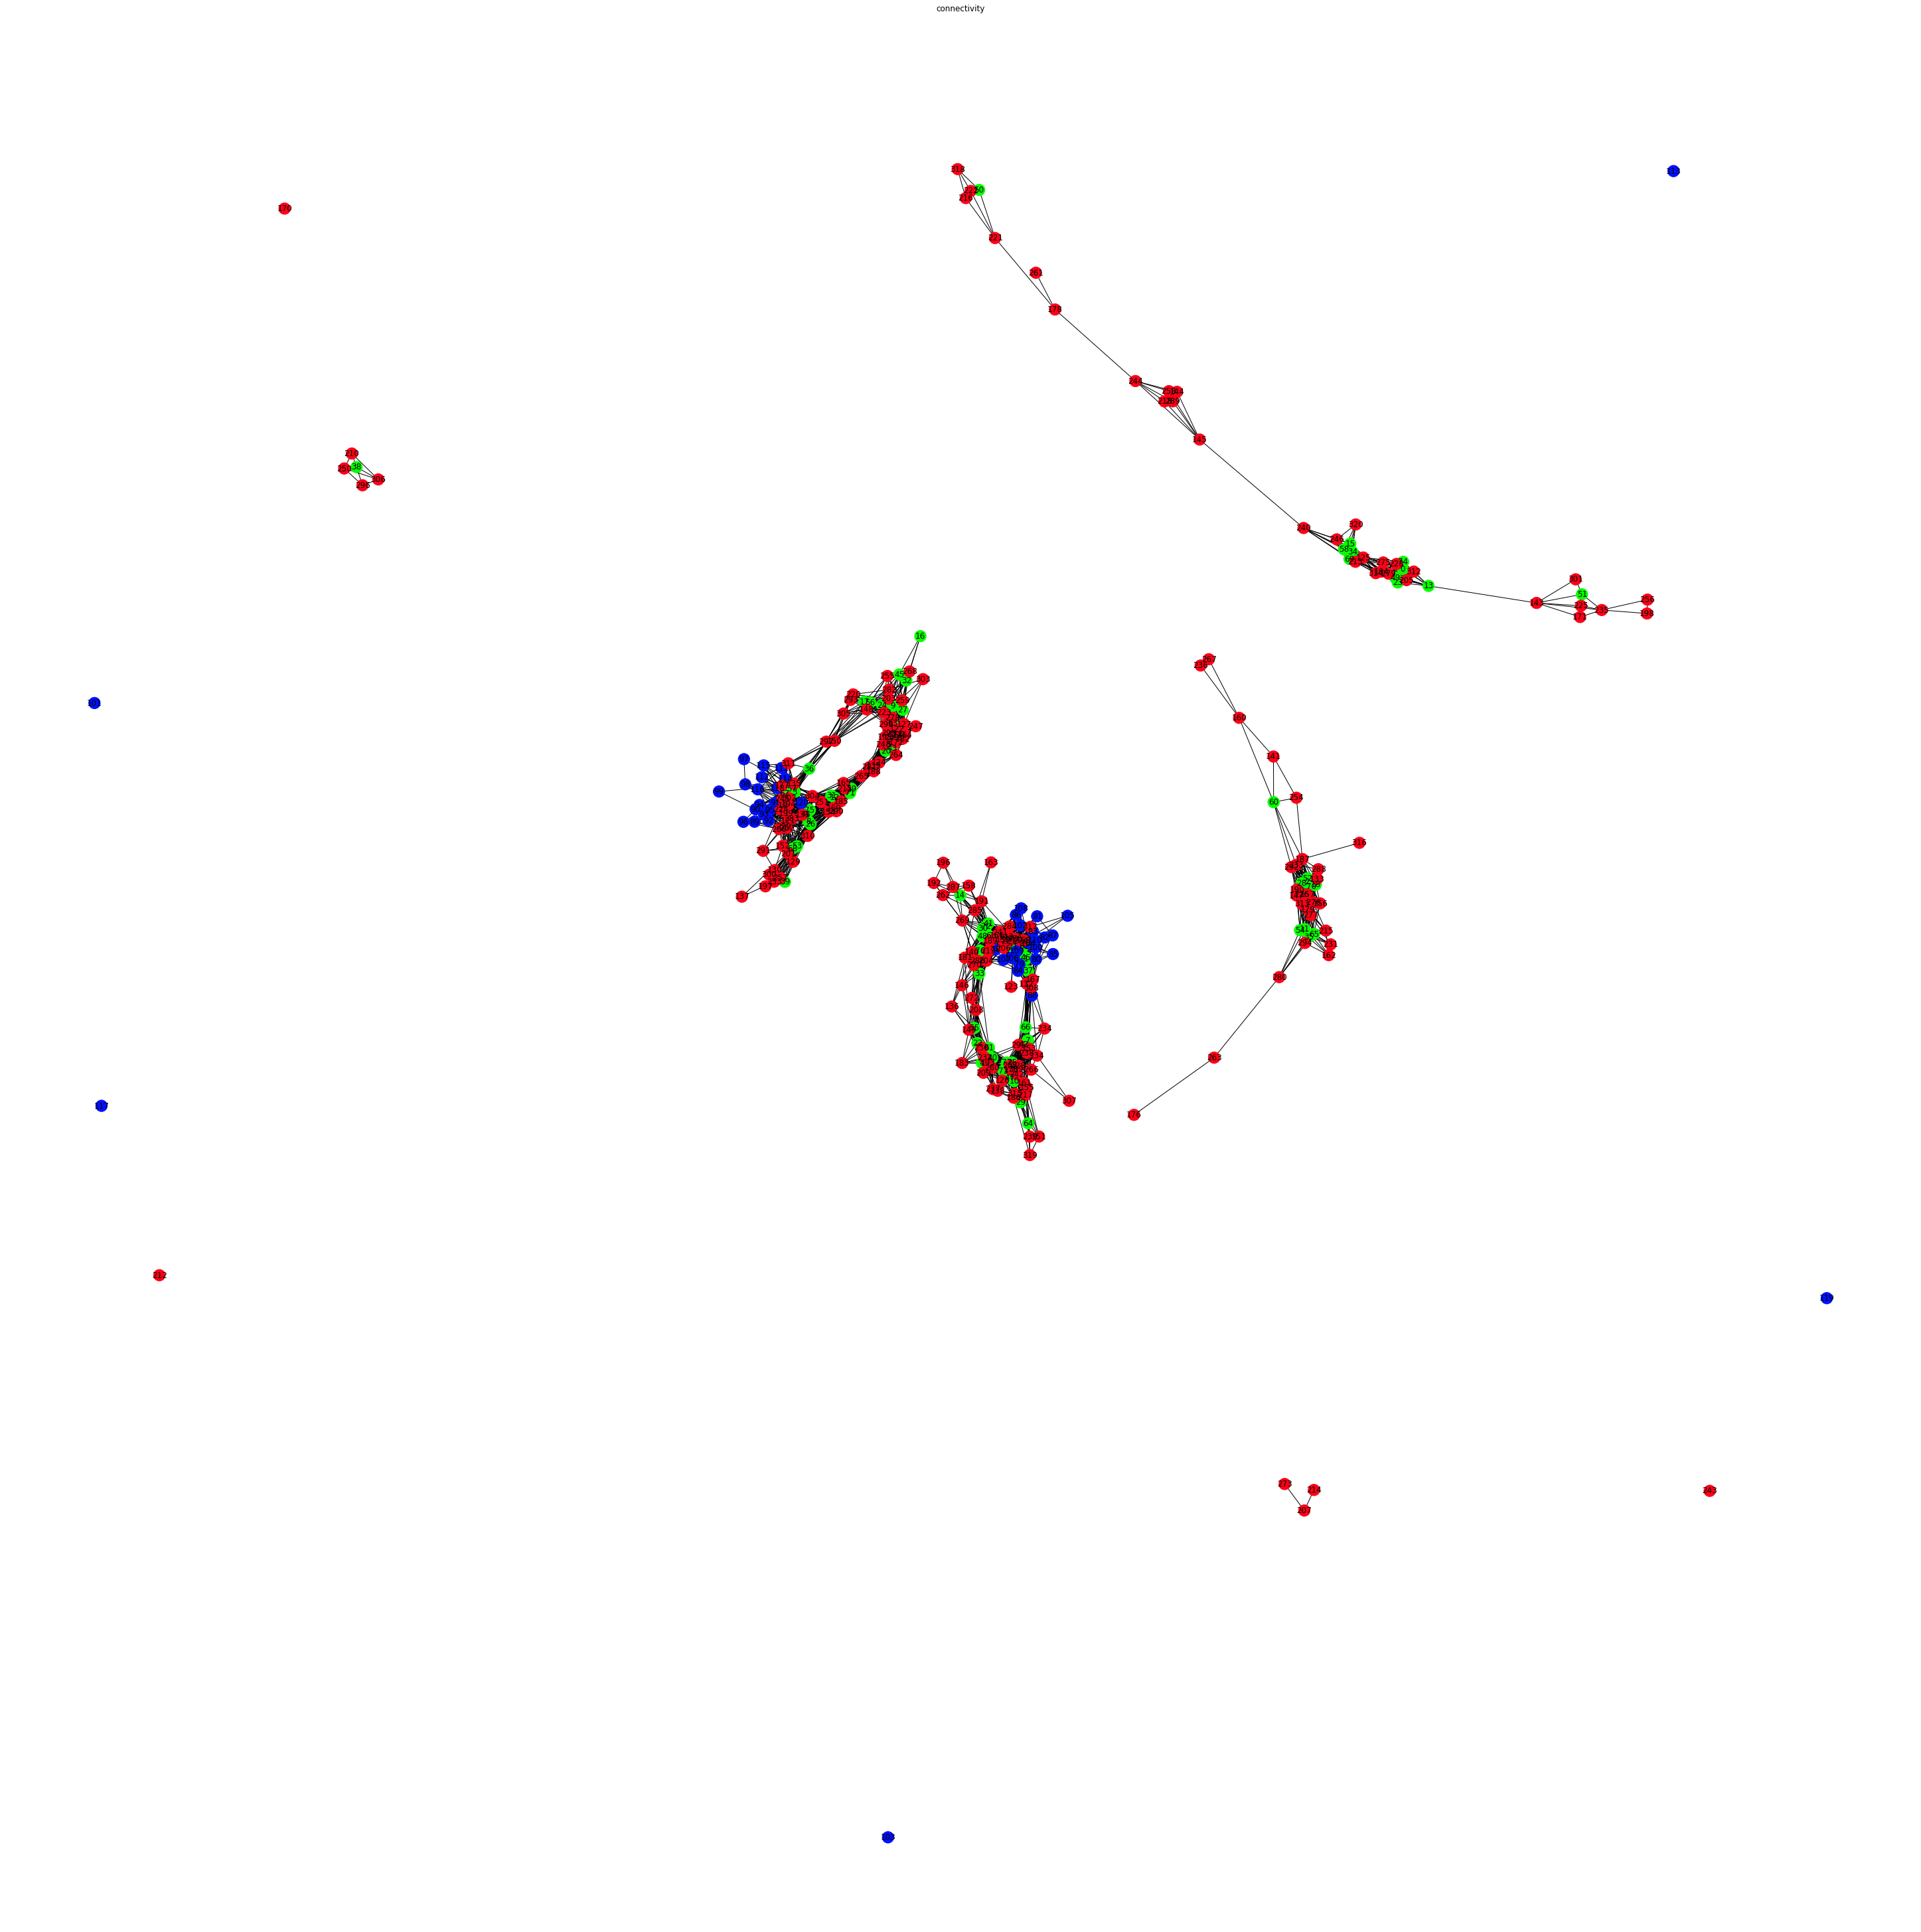

In [19]:
fig = plt.figure(figsize=(40,40))

regions_connected_component = [regs[i] for i in largest_con_comp]
# plt.scatter(X_tsne[:len(regions_c),0], X_tsne[:len(regions_c),1], c = 'k')
# plt.scatter(X_tsne[len(regions_c):,0], X_tsne[len(regions_c):,1], c = 'r')
# nx.draw_networkx_edges(connectivity_graph, X_tsne)

hues = generate_distinct_colors(3+1)[1:]
colors = []
for g, h in zip([ regions_c, regions_red, connector_samples], hues):
    colors += [h]*len(g)

nx.draw_spring(connectivity_graph, 
                with_labels = True, 
                node_color = colors)
plt.title(f"connectivity")

In [20]:
#print(list(connectivity_graph.neighbors(141)))
bridge_point1 = np.array([-0.25690557, -0.89316598, -0.34485379, -2.0275082 , -1.89302384,
       -1.55071103,  1.93542542])
bridge_point2 = regs[36].ChebyshevCenter()

In [19]:
ccs = [list(cc) for cc in list(nx.connected_components(connectivity_graph))]
neigh = list(connectivity_graph.neighbors(141))
neigh_ccidx = []
for n in neigh:
    for i,cc in enumerate(ccs):
        if n in cc:
            neigh_ccidx.append()


NetworkXError: The node 141 is not in the graph.

In [59]:
bridge_point = np.array([-0.25690557, -0.89316598, -0.34485379, -2.0275082 , -1.89302384,
       -1.55071103,  1.93542542])
#bridge_point = connector_samples[20]

In [60]:
bridge_point

array([-0.25690557, -0.89316598, -0.34485379, -2.0275082 , -1.89302384,
       -1.55071103,  1.93542542])

In [21]:
def gs(X, row_vecs=True, norm = True):
    if not row_vecs:
        X = X.T
    Y = X[0:1,:].copy()
    for i in range(1, X.shape[0]):
        proj = np.diag((X[i,:].dot(Y.T)/np.linalg.norm(Y,axis=1)**2).flat).dot(Y)
        Y = np.vstack((Y, X[i,:] - proj.sum(0)))
    if norm:
        Y = np.diag(1/np.linalg.norm(Y,axis=1)).dot(Y)
    if row_vecs:
        return Y
    else:
        return Y.T

def aligned_box(pa, pb, longitudinal_margin= 1e-3, lateral_margin = 0.1):
    assert len(pa) == len(pb)
    dim = len(pa)
    rab = pb-pa
    n = (rab/(np.linalg.norm(pb-pa) + 1e-6)).reshape(1,-1)
    basis = gs(np.concatenate((n, np.random.randn(dim-1, dim)), axis=0))
    A = np.zeros((2*dim, dim))
    b = np.zeros((2*dim))
    A[0, :] = -basis[0, :]
    b[0] = -basis[0, :]@pa + longitudinal_margin
    A[1, :] = basis[0, :]
    b[1] = basis[0, :]@pb + longitudinal_margin
    for i in range(1, dim):
        A[2*i, :] = -basis[i, :]
        b[2*i] = -basis[i, :]@pa + lateral_margin
        A[2*i+1, :] = basis[i, :]
        b[2*i+1] = basis[i, :]@pa + lateral_margin
    return HPolyhedron(A,b)

from pydrake.all import RandomGenerator
from irisbs import IRISBS
# def bisect_collision_point(coll_free, coll, checker, N_steps=5):
#     curr_coll = coll
#     curr_coll_free = coll_free
#     for _ in range(N_steps):
#         curr = (curr_coll+curr_coll_free)/2
#         if checker.CheckConfigCollisionFree(curr):
#             curr_coll_free = curr
#         else:
#             #print('col updated')
#             curr_coll = curr
#     return curr

# def gradient_descent(ellipsoid, point_in_collision, checker, gradient_steps=1, bisection_steps=5):
#     curr = point_in_collision.copy()
#     ATA = ellipsoid.A().T@ellipsoid.A()
#     for _ in range(gradient_steps):
#         grad = ATA@(curr-ellipsoid.center())
#         grad = grad/np.linalg.norm(grad)
#         dist = -(grad.T@ATA@(curr-ellipsoid.center()))/(grad.T@ATA@grad)
#         next_point = curr + dist*grad
#         if not checker.CheckConfigCollisionFree(next_point):
#             curr = next_point
#         else:
#             #do bisection
#             curr = bisect_collision_point(next_point, curr, checker, N_steps=bisection_steps)
#     return curr

# def tangent_hyperplane(ellipse, point, backoff):
#     a = ellipse.A().T@ellipse.A()@(point - ellipse.center())
#     a = a/(np.linalg.norm(a) +1e-6)
#     b = a@point - backoff
#     return a.reshape(1,-1), b

# def IRISBS(domain, starting_ellipse, checker, N = 100, NumFails = 100, backoff = 1e-5, gradient_steps = 5, bisection_steps = 5, use_bisection_only = False):
#     H = HPolyhedron(domain.A(), domain.b())
#     seedp = starting_ellipse.center()
#     gen = RandomGenerator(1)
#     num_consec_fails = 0
#     prev = seedp
#     iters = 0
#     while num_consec_fails < NumFails: 
#         if iters%50 == 0:
#             print(f"iterations: {iters}, #faces {H.A().shape[0]}, seed point contained {H.PointInSet(seedp)}")
#         samples = []
#         new_faces_a = []
#         new_faces_b = []
#         for _ in range(N):
#             curr = H.UniformSample(gen, prev)
#             samples.append(curr)
#             prev = curr.copy()
#         #print('sampling done')
#         in_col = checker.CheckConfigsCollisionFree(np.array(samples))
#         samples = sorted([samples[i] for i in in_col], 
#                             key=lambda x: 
#                             (x - seedp).T@starting_ellipse.A().T@starting_ellipse.A()@(x - seedp))
#         #print('sorting done')
#         #print('checking done')
#         remaining_idx = np.where(1-np.array(in_col))[0]
#         #print(np.where(1-np.array(in_col)))
#         #print(f"nr in col {len(remaining_idx)}")
#         if not len(remaining_idx):
#             num_consec_fails +=1
#             #print("hahah", num_consec_fails)
#         else:
#             num_consec_fails = 0
#         while len(remaining_idx):
#             start = samples[remaining_idx[0]]
#             if use_bisection_only:
#                 boundary_point = bisect_collision_point(seedp, start, checker, N_steps = bisection_steps)
#             else:
#                 boundary_point = gradient_descent(starting_ellipse, start, checker, gradient_steps=gradient_steps, bisection_steps=bisection_steps)#
#             a, b = tangent_hyperplane(starting_ellipse, boundary_point, backoff)
#             remaining_idx = np.delete(remaining_idx, 0)
#             is_redunant = np.where([a@samples[id]-b>=0 for id in remaining_idx])[0]
#             remaining_idx = np.delete(remaining_idx, is_redunant)
#             new_faces_a.append(a)
#             new_faces_b.append(b)
#         H = HPolyhedron(np.concatenate(tuple([H.A()] + new_faces_a ), axis = 0,), 
#                         np.concatenate((H.b(), np.array(new_faces_b) ), axis = 0,))

#         #print(H.PointInSet(seedp))
#         #print(H.A().shape)
#         #print(H.MaximumVolumeInscribedEllipsoid().Volume())
#         iters+=1
#         prev = H.UniformSample(gen)
#     return H


In [22]:

domain = aligned_box(bridge_point1, bridge_point2, longitudinal_margin=1.5, lateral_margin= 1.5)
starting_ellipse= domain.MaximumVolumeInscribedEllipsoid()
reg_bis = IRISBS(domain, starting_ellipse, checker, N =10, bisection_steps=25, use_bisection_only=True)
print(f"vol, {reg_bis.MaximumVolumeInscribedEllipsoid().Volume()}")
reg_gs = IRISBS(domain, starting_ellipse, checker, N =10, gradient_steps=2, bisection_steps=8, use_bisection_only=False)
print(f"vol, {reg_gs.MaximumVolumeInscribedEllipsoid().Volume()}")

iterations: 0, #faces 14, seed point contained True
iterations: 50, #faces 47, seed point contained True
iterations: 100, #faces 52, seed point contained True
iterations: 150, #faces 58, seed point contained True
iterations: 200, #faces 60, seed point contained True
iterations: 250, #faces 61, seed point contained True
iterations: 300, #faces 65, seed point contained True
iterations: 350, #faces 66, seed point contained True
iterations: 400, #faces 68, seed point contained True
iterations: 450, #faces 68, seed point contained True
vol, 3.330602576165884e-05
iterations: 0, #faces 14, seed point contained True
iterations: 50, #faces 57, seed point contained True
iterations: 100, #faces 71, seed point contained True
iterations: 150, #faces 80, seed point contained True
iterations: 200, #faces 86, seed point contained True
iterations: 250, #faces 91, seed point contained True
iterations: 300, #faces 92, seed point contained True
iterations: 350, #faces 97, seed point contained True
iterati

In [23]:
require_sample_point_is_contained = True
iteration_limit = 1
configuration_space_margin = 1.e-3
termination_threshold = -1
num_collision_infeasible_samples = 100
relative_termination_threshold = 0.02
estimate_coverage = get_coverage_estimator(sample_cfree, pts = 3000)

snopt_iris_options = IrisOptions()
snopt_iris_options.require_sample_point_is_contained = require_sample_point_is_contained
snopt_iris_options.iteration_limit = iteration_limit
snopt_iris_options.configuration_space_margin = configuration_space_margin
#snopt_iris_options.max_faces_per_collision_pair = 60
snopt_iris_options.termination_threshold = termination_threshold
#snopt_iris_options.q_star = np.zeros(3)
snopt_iris_options.num_snopt_seed_guesses = 100
snopt_iris_options.num_collision_infeasible_samples = num_collision_infeasible_samples
snopt_iris_options.relative_termination_threshold = relative_termination_threshold

In [28]:
pts, is_full = sample_cfree(5, 50, [])
metrics = [Hyperellipsoid.MakeHypersphere( 1e-3, pt) for pt in pts]


In [29]:
regions_rand =  SNOPT_IRIS_ellipsoid_parallel(pts, metrics,[], [], None, plant_builder, snopt_iris_options, estimate_coverage, coverage_threshold=1)

INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake: Checking wsg::collision against shelves2::shelf_upper has already required 1000 counter-example searches; still searching...
INFO:drake: Checking wsg::collision against shelves2::top has already required 1000 counter-example searches; still searching...
INFO:drake: Finished checking wsg::collision against shelves2::top after 1136 counter-example searches.
INFO:drake: Finished checking wsg::collision against shelves2::shelf_upper after 1431 counter-example searches.
INFO:drake: Checking iiwa::iiwa_link_5_collision against ground::Box has already required 1000 counter-example searches; still searching...
INFO:drake: Finished checking iiwa::iiwa_link_5_collision against ground::Box after 1102 counter-example searches.


[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1


([], [], False)

In [36]:
domain = HPolyhedron.MakeBox(plant.GetPositionLowerLimits(), plant.GetPositionUpperLimits())
regs_irisbs = []
for pt, met in zip(pts, metrics):
    r = IRISBS(domain, met, checker, backoff=1e-3, N = 1000, NumFails=10, use_bisection_only=False)
    regs_irisbs.append(r)

iterations: 0, #faces 14, seed point contained True
iterations: 50, #faces 226, seed point contained True
iterations: 100, #faces 269, seed point contained True
iterations: 150, #faces 289, seed point contained True
iterations: 0, #faces 14, seed point contained True
iterations: 50, #faces 284, seed point contained True
iterations: 100, #faces 329, seed point contained True
iterations: 150, #faces 369, seed point contained True
iterations: 0, #faces 14, seed point contained True
iterations: 50, #faces 146, seed point contained True
iterations: 100, #faces 158, seed point contained True
iterations: 0, #faces 14, seed point contained True
iterations: 50, #faces 275, seed point contained True
iterations: 100, #faces 313, seed point contained True
iterations: 150, #faces 335, seed point contained True
iterations: 200, #faces 352, seed point contained True
iterations: 250, #faces 370, seed point contained True
iterations: 0, #faces 14, seed point contained True
iterations: 50, #faces 141, s

In [31]:
[r.MaximumVolumeInscribedEllipsoid().Volume() for r in regions_rand[0]]

[0.005279061652613151,
 0.00019691975422080185,
 0.0007618619047615164,
 0.00352091055418628,
 0.001874107669448219]

In [37]:
[r.MaximumVolumeInscribedEllipsoid().Volume() for r in regs_irisbs]

[0.00042595364618556585,
 2.2277496278555825e-05,
 8.983926854192126e-05,
 4.733908885538661e-06,
 3.581992582002131e-06]

In [33]:
r = regions_c[0]

In [48]:
from pydrake.all import IrisInConfigurationSpace
array([[ 2.92242981, -0.36018966,  2.02456924,  1.64032211,  0.41974906,
         -0.48462897,  0.30781041]])

plant.SetPositions()
IrisInConfigurationSpace(plant, diagram_context, snopt_iris_options)

In [124]:
np.argmax([r.MaximumVolumeInscribedEllipsoid().Volume() for r in regions_c])

23

In [125]:
regions_c[23].MaximumVolumeInscribedEllipsoid().center()

array([-1.97366644e-02, -1.37442460e+00,  9.07447445e-01,  2.11621547e-02,
        4.78979523e-10,  1.19457730e-01,  5.51976687e-10])

In [36]:
# seedp = np.array([-1.97366644e-02, -1.37442460e+00,  9.07447445e-01,  2.11621547e-02,
#         4.78979523e-10,  1.19457730e-01,  5.51976687e-10])
starting_ellipse = regions_c[23].MaximumVolumeInscribedEllipsoid()
domain = HPolyhedron.MakeBox(plant.GetPositionLowerLimits(), plant.GetPositionUpperLimits())
reg_bs = IRISBS(domain, starting_ellipse, checker, N = 100)
print(reg_bs.MaximumVolumeInscribedEllipsoid().Volume())


iterations: 0, #faces 14, seed point contained True
iterations: 50, #faces 75, seed point contained True
iterations: 100, #faces 105, seed point contained True
iterations: 150, #faces 113, seed point contained True
iterations: 200, #faces 115, seed point contained True
iterations: 250, #faces 117, seed point contained True
iterations: 300, #faces 119, seed point contained True
iterations: 350, #faces 119, seed point contained True
0.11481200427332178


In [37]:
reg_bs.MaximumVolumeInscribedEllipsoid().Volume()

0.11481200427332178

In [44]:
A = reg_bs.MaximumVolumeInscribedEllipsoid().A()
ATA = A.T@A
np.linalg.eig(ATA)[0]

array([1.58587171e+02, 3.11929091e+01, 1.18163598e+01, 1.65869690e+00,
       5.24274498e-01, 1.27700998e-01, 2.60890529e-01])

In [45]:
A = regions_c[23].MaximumVolumeInscribedEllipsoid().A()
ATA = A.T@A
np.linalg.eig(ATA)[0]

array([29.12116673,  7.7032298 ,  2.7670873 ,  0.45482259,  0.22904877,
        0.11076216,  0.10666547])

In [41]:
check_collision_frac(reg_bs, 10000, checker)

0.0157

In [40]:
def check_collision_frac(region, N, checker):
    gen = RandomGenerator(np.random.randint(109))
    prev = region.ChebyshevCenter()
    num_coll = 0
    for _ in range(N):
        prev = region.UniformSample(gen, prev)
        if not checker.CheckConfigCollisionFree(prev):
            num_coll +=1
    return 1.0*num_coll/N

In [92]:
domain = HPolyhedron.MakeBox(plant.GetPositionLowerLimits(), plant.GetAccelerationUpperLimits())
se = Hyperellipsoid.MakeHypersphere(,)

SyntaxError: invalid syntax (<ipython-input-92-8f7c001ab085>, line 2)

In [ ]:
lambda x: np.linalg.norm(x-np.array())

(-0.13152924972015312,
 0.2315292497201531,
 -0.13684921933728147,
 0.23684921933728145)

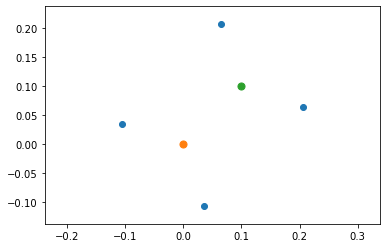

In [89]:
p1, p2 = np.array([0,0]), np.array([.1,0.1])
box = aligned_box(p1, p2, longitudinal_margin=0.05)
verts = VPolytope(box).vertices().T
plt.figure()
plt.scatter(verts[:,0], verts[:, 1])
plt.xlim([-0.2,0.2])
plt.ylim([-0.2,0.2])
plt.scatter(p1[0], p1[1], s = 50)
plt.scatter(p2[0], p2[1], s = 50)
plt.axis('equal')

In [61]:
print(box.A())
print(box.b())

[[-1. -0.]
 [ 1.  0.]
 [-0.  1.]
 [ 0. -1.]]
[-1.000e-03  1.001e+00  1.000e-01  0.000e+00]


In [ ]:
vg = vgraph_handle(connector_samples)

In [23]:
connected_components = [list(cc) for cc in list(nx.connected_components(connectivity_graph))]

In [24]:
vis_edges =[]

for i, c1 in enumerate(connected_components):
    print(i)
    for c2 in connected_components[i+1:]:
        for i_c1 in c1:
            for i_c2 in c2:
                center1, center2 = center_locations[i_c1], center_locations[i_c2]
                if checker.CheckEdgeCollisionFreeParallel(center1, center2):
                    vis_edges.append([i_c1, i_c2])
                    connectivity_graph.add_edge(i_c1, i_c2)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


Text(0.5, 1.0, 'connectivity')

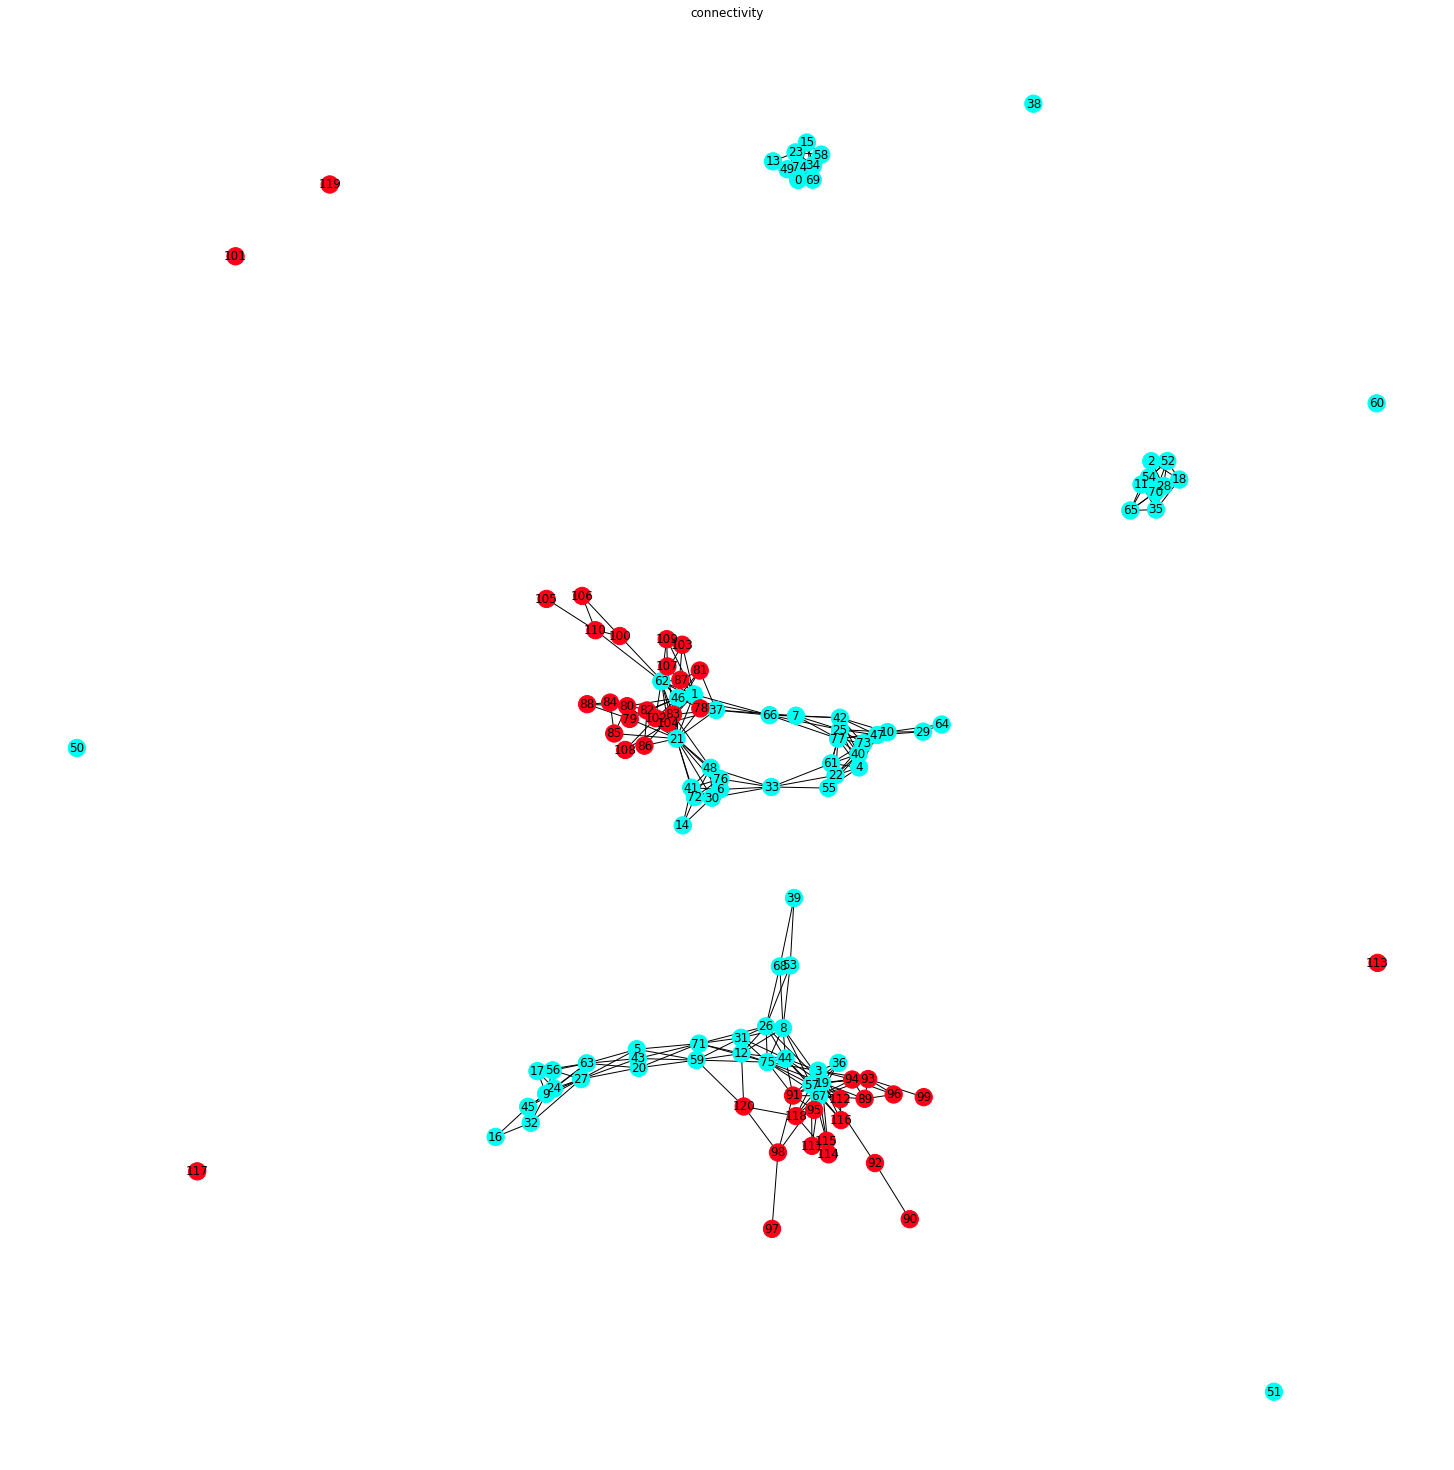

In [25]:
fig = plt.figure(figsize=(20,20))

#regions_connected_component = [regs[i] for i in largest_con_comp]
#plt.scatter(X_tsne[:len(regions_c),0], X_tsne[:len(regions_c),1], c = 'k')
#plt.scatter(X_tsne[len(regions_c):,0], X_tsne[len(regions_c):,1], c = 'r')
#nx.draw_networkx_edges(connectivity_graph, X_tsne)

hues = generate_distinct_colors(2+1)[1:]
colors = []
for g, h in zip([ regions_c, regions_red], hues):
    colors += [h]*len(g)

nx.draw_spring(connectivity_graph, 
                with_labels = True, 
                node_color = colors[:len(regs)])
plt.title(f"connectivity")

In [26]:
for c in center_locations:
    showres(c)
    time.sleep(0.1)

In [13]:
from pydrake.all import RandomGenerator

def sample_n_per_region(N, regions):
    
    samples = []
    for i, r in enumerate(regions):
        gen = RandomGenerator(i)
        prev = r.ChebyshevCenter()
        for _ in range(N):
            curr = r.UniformSample(gen, prev)
            samples.append(curr)
            prev = curr.copy()
    return samples

In [14]:
from visibility_utils import get_sample_cfree_handle, get_col_func

scaler = 1 #np.array([0.8, 1., 0.8, 1, 0.8, 1, 0.8]) 
q_min = plant.GetPositionLowerLimits()*scaler
q_max =  plant.GetPositionUpperLimits()*scaler

col_func_handle_ = get_col_func(plant, plant_context)
sample_cfree = get_sample_cfree_handle(q_min,q_max, col_func_handle_)

/home/peter/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/peter/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


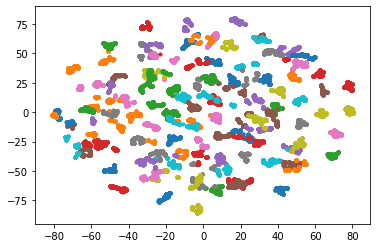

In [22]:
plt.figure()
N = 200
samples = sample_n_per_region(N, regs)
#verts = (VPolytope(regs[0]).vertices().T)[:1000]
#pca = PCA(n_components=2)
#X_tsne = pca.fit_transform(verts)
tsne = TSNE(early_exaggeration=15, perplexity=80)

X_tsne = tsne.fit_transform(np.array(samples))
for i in range(len(regs)):
    plt.scatter(X_tsne[i*N :(i+1)*N, 0], X_tsne[i*N :(i+1)*N, 1], s=10)

plt.show()


In [54]:
sample_cfree(1000, 50, [])

(array([], dtype=float64), True)

In [41]:
ell = regs[0].MaximumVolumeInscribedEllipsoid()

In [47]:
np.linalg.eig(ell.A().T @ell.A())[0]

array([28.01304163,  8.24952269,  3.12161981,  0.48127559,  0.25035118,
        0.11219371,  0.10677298])

In [43]:
ell.A().shape

(7, 7)

Text(0.5, 1.0, 'connectivity')

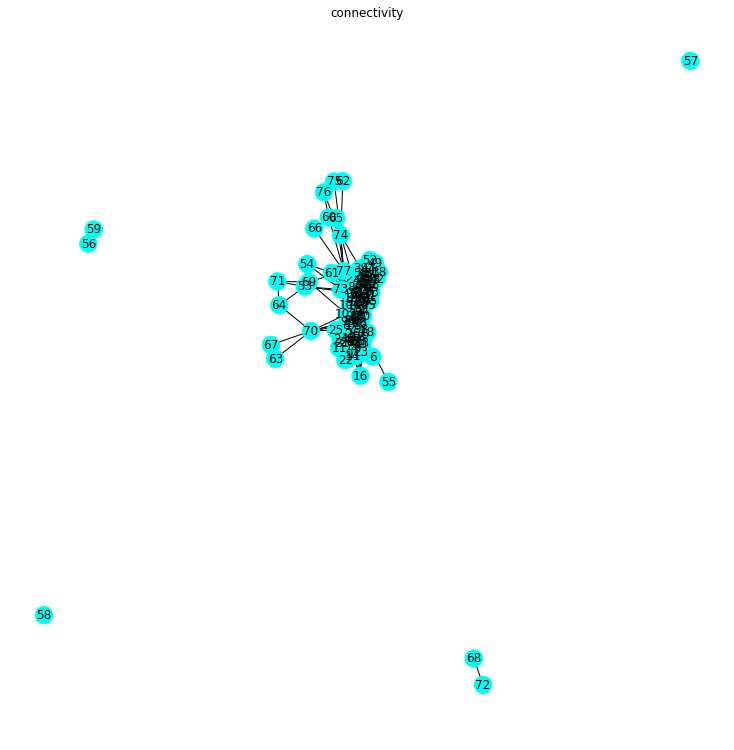

In [13]:
import networkx as nx
import matplotlib.pyplot as plt
from visibility_utils import generate_distinct_colors
regs = regions_shelves+regions_c
connectivity_graph = nx.Graph()
for idx in range(len(regs)):
    connectivity_graph.add_node(idx)

for idx1 in range(len(regs)):
    for idx2 in range(idx1 +1, len(regs)):
        r1 = regs[idx1]
        r2 = regs[idx2]
        if r1.IntersectsWith(r2):
            connectivity_graph.add_edge(idx1,idx2)

largest_con_comp = list(list(nx.connected_components(connectivity_graph))[0])
regions_connected_component = [regs[i] for i in largest_con_comp]

fig = plt.figure(figsize=(10,10))
hues = generate_distinct_colors(2+1)[1:]
colors = []
for g, h in zip([regs], hues):
    colors += [h]*len(g)

nx.draw_spring(connectivity_graph, 
                with_labels = True, 
                node_color = colors)
plt.title(f"connectivity")

In [14]:
from dijkstraspp import DijkstraSPP
# checker_dspp = SceneGraphCollisionChecker(model = diagram,#.Clone(), 
#                     robot_model_instances = robot_instances,
#                     distance_function_weights =  [1] * plant.num_positions(),
#                     #configuration_distance_function = _configuration_distance,
#                     edge_step_size = 0.01)
dspp = DijkstraSPP(regions_connected_component, checker, verbose=True)

[DijkstraSPP] Pre-Building adjacency matrix  0 / 101
[DijkstraSPP] Pre-Building adjacency matrix  10 / 101
[DijkstraSPP] Pre-Building adjacency matrix  20 / 101
[DijkstraSPP] Pre-Building adjacency matrix  30 / 101
[DijkstraSPP] Pre-Building adjacency matrix  40 / 101
[DijkstraSPP] Pre-Building adjacency matrix  50 / 101
[DijkstraSPP] Pre-Building adjacency matrix  60 / 101
[DijkstraSPP] Pre-Building adjacency matrix  70 / 101
[DijkstraSPP] Pre-Building adjacency matrix  80 / 101
[DijkstraSPP] Pre-Building adjacency matrix  90 / 101
[DijkstraSPP] Pre-Building adjacency matrix  100 / 101
[DijkstraSPP] Pre-Building safe-adjacency matrix  0 / 101
[DijkstraSPP] Pre-Building safe-adjacency matrix  10 / 101
[DijkstraSPP] Pre-Building safe-adjacency matrix  20 / 101
[DijkstraSPP] Pre-Building safe-adjacency matrix  30 / 101
[DijkstraSPP] Pre-Building safe-adjacency matrix  40 / 101
[DijkstraSPP] Pre-Building safe-adjacency matrix  50 / 101
[DijkstraSPP] Pre-Building safe-adjacency matrix  60 

In [15]:
q_tot = np.concatenate(tuple(q_obj))

In [16]:
q_obj_vis_idx = []
for i in range(3):
    visible_centers = check_visibility_to_regions(q_obj[i], regions_connected_component, checker)
    visibility_coverage = np.mean([1 if len(v) else 0 for v in visible_centers])
    print(visibility_coverage)
    q_obj_vis_idx.append(np.where([len(v) for v in visible_centers])[0])

0.994
0.996
0.532


In [17]:
q_obj_vis = [q_obj[i][qidx] for i, qidx in enumerate(q_obj_vis_idx)]

In [18]:
meshcat.Delete('/iris/shunk')
plot_endeff_poses(meshcat, np.concatenate(tuple(q_obj_vis),axis = 0)[::3])

In [19]:
import time
from visibility_utils import point_in_regions
centers = [r.ChebyshevCenter() for r in regions_connected_component]

# meshcat.SetProperty(f"/drake/visualizer/shunk", "visible", False)
objs = [0,1,2,2,2]

np.random.seed(132)
start = centers[1]
cur_time = 0
obj = 0
dist_ratio = []
cols = []
for _ in range(100):
    #nxt = vs.sample_in_regions() #
    nxt = q_obj_vis[obj][np.random.choice(len(q_obj_vis[obj]))]
    objidx = np.random.choice(len(objs))
    obj = objs[objidx]
    t1 = time.time()
    wp, dist = dspp.solve(start, nxt, refine_path=True)#dijkstra_spp(start, nxt, node_intersections, base_ad_mat, vs.regions, point_conversion, optimize= True)
    t2 = time.time()
    print(f"plan time {t2-t1:.3f}")
    #wp2, dist2 = dspp2.solve(start, nxt, refine_path=True)
    #dist_ratio.append([dist, dist2])
    #print(dist)
    meshcat.Delete("/iris/points/traj/")
    dense_waypoints = densify_waypoints(wp, densify=100)
    dense_waypoints_plt = densify_waypoints(wp, densify=90)
    plot_endeff_traj(dense_waypoints_plt)
    print(len(dense_waypoints))
    for qa in dense_waypoints:
        #anim_endeff_traj(dense_waypoints_plt, animation, frame)
        #qa = #Ratfk.ComputeQValue(ta, np.zeros(3))
        showres(qa)
        #diagram_context.SetTime(cur_time)
        if not checker.CheckConfigCollisionFree(qa):
            print('col')
            cols.append(wp)
            
            break
            # for idx, r in enumerate(regions_connected_component):
            #     if point_in_regions(qa, [r]):
            #         print(f"collision in region {largest_con_comp[idx]}")
            #break
        #frame+=1
        time.sleep(0.01)
    start = nxt.copy()
    time.sleep(0.01)
        
        # meshcat.Delete("/iris/points/traj/")

[DijkstraSPP] Attempting visibility extension for end
[DijkstraSPP] optimized distance/ start-distance = 4.95 / 5.17 = 0.96
plan time 0.124
89
[DijkstraSPP] Attempting visibility extension for start
[DijkstraSPP] Attempting visibility extension for end
[DijkstraSPP] optimized distance/ start-distance = 8.32 / 9.13 = 0.91
plan time 0.152
178
[DijkstraSPP] Attempting visibility extension for start
[DijkstraSPP] Attempting visibility extension for end
[DijkstraSPP] optimized distance/ start-distance = 11.46 / 12.14 = 0.94
plan time 0.155
190
[DijkstraSPP] Attempting visibility extension for start
[DijkstraSPP] Attempting visibility extension for end
[DijkstraSPP] optimized distance/ start-distance = 8.81 / 9.60 = 0.92
plan time 0.140
142
[DijkstraSPP] Attempting visibility extension for start
[DijkstraSPP] Attempting visibility extension for end
[DijkstraSPP] optimized distance/ start-distance = 4.57 / 4.96 = 0.92
plan time 0.156
73
[DijkstraSPP] Attempting visibility extension for start


In [ ]:
meshcat.SetProperty(f"/Grid", "visible", False)
meshcat.SetProperty(f"/Background", "visible", False)
meshcat.SetProperty(f"/Axes", "visible", False)

In [36]:
def hide_traj(name, anim, frame):
    for i in range(500):
        anim.SetTransform(frame,name + str(i), RigidTransform(
                            RotationMatrix(), 
                            np.array([0,0,1000])))
        
def anim_endeff_traj(dense_waypoints, anim, frame):
    #color = Rgba(1,0,0,1.0)
    start_idx = 0
    for i, qa in enumerate(dense_waypoints):
        #qa = Ratfk.ComputeQValue(ta, np.zeros(7))
        #showres(qa)
        #time.sleep(0.1)            
        plant.SetPositions(plant_context, qa)
        tf_tot=  plant.EvalBodyPoseInWorld(plant_context,  plant.GetBodyByName('body'))
        tf = tf_tot.translation()+tf_tot.rotation()@np.array([0,0.1,0])

        #  meshcat.SetObject(f"/iris/points/traj/{i+start_idx}",
        #                        Sphere(0.005),
        #                        color)

        anim.SetTransform(frame,f"/iris/points/traj/{i+start_idx}",
                                   RigidTransform(RotationMatrix(),
                                                  tf))
    # plant.SetPositions(plant_context, qvis)
    # diagram.ForcedPublish(diagram_context)
    # tf =plant.EvalBodyPoseInWorld(plant_context,  plant.GetBodyByName(endeff_frame))
    # transl = tf.translation()+tf.rotation()@np.array([0,0.1,0])
    # if show_body_frame is not None:
    #     show_body_frame(RigidTransform(tf.rotation(), transl))

def anim_endeff_triad(qa, anim, frame):
    plant.SetPositions(plant_context, qa)
    h = 0.2
    pose =  plant.EvalBodyPoseInWorld(plant_context,  plant.GetBodyByName('body'))
    rot = pose.rotation()@RotationMatrix.MakeYRotation(np.pi/2)
    pos= pose.translation() +pose.rotation()@np.array([0,0.1,0]) +pose.rotation()@np.array([h/2, 0,0])
    
    anim.SetTransform(frame,f"/drake/ik_targetendeff_actual/triad1",
                                   RigidTransform(rot, pos))
    rot = pose.rotation()@RotationMatrix.MakeXRotation(-np.pi/2)
    pos= pose.translation() +pose.rotation()@np.array([0,0.1,0])+pose.rotation()@np.array([0,h/2,0])
    anim.SetTransform(frame,f"/drake/ik_targetendeff_actual/triad2",
                                   RigidTransform(rot, pos))
    rot = pose.rotation()
    pos = pose.translation()+ pose.rotation()@np.array([0,0.1,0])+rot@np.array([0,0,h/2])
    anim.SetTransform(frame,f"/drake/ik_targetendeff_actual/triad3",
                                   RigidTransform(rot, pos))


In [37]:
meshcat.Delete(f"/drake/ik_targetendeff_acutal")

In [38]:
import time
from visibility_utils import point_in_regions
centers = [r.ChebyshevCenter() for r in regions_connected_component]
plot_endeff_traj([np.zeros(7) for _ in range(500)])

frame_time = 1/32.0
cur_time = 0
meshcat.StartRecording()
animation = meshcat.get_mutable_recording()
meshcat.SetProperty(f"/Grid", "visible", False)
meshcat.SetProperty(f"/Background", "visible", True)
meshcat.SetProperty(f"/Axes", "visible", False)
meshcat.SetProperty(f"/shunk", "visible", True)
meshcat.SetProperty(f"/iris/regionsbinL", "visible", False)
meshcat.SetProperty(f"/iris/regionsbinR", "visible", False)
meshcat.SetProperty(f"/iris/regionsshelves", "visible", False)
objs = [0,1,2,2,2]

np.random.seed(132)
start = centers[1]
cur_time = 0
obj = 0
dist_ratio = []
cols = []
frame = 0
hide_traj("/iris/points/traj/",animation ,frame)
for _ in range(20):
    #nxt = vs.sample_in_regions() #
    nxt = q_obj_vis[obj][np.random.choice(len(q_obj_vis[obj]))]
    objidx = np.random.choice(len(objs))
    obj = objs[objidx]
    t1 = time.time()
    wp, dist = dspp.solve(start, nxt, refine_path=True)#dijkstra_spp(start, nxt, node_intersections, base_ad_mat, vs.regions, point_conversion, optimize= True)
    t2 = time.time()
    print(f"plan time {t2-t1:.3f}")
    #wp2, dist2 = dspp2.solve(start, nxt, refine_path=True)
    #dist_ratio.append([dist, dist2])
    #print(dist)
    #meshcat.Delete("/iris/points/traj/")
    hide_traj("/iris/points/traj/",animation ,frame)
    dense_waypoints = densify_waypoints(wp, densify=100)
    dense_waypoints_plt = densify_waypoints(wp, densify=90)
    #plot_endeff_traj(dense_waypoints_plt)
    print(len(dense_waypoints))
    for qa in dense_waypoints[::2]:
        anim_endeff_traj(dense_waypoints_plt, animation, frame)
        
        #qa = #Ratfk.ComputeQValue(ta, np.zeros(3))
        showres(qa)
        anim_endeff_triad(qa, animation, frame)
        diagram_context.SetTime(cur_time)
        if not checker.CheckConfigCollisionFree(qa):
            print('col')
            cols.append(wp)
            time.sleep(10)
            break
            # for idx, r in enumerate(regions_connected_component):
            #     if point_in_regions(qa, [r]):
            #         print(f"collision in region {largest_con_comp[idx]}")
            #break
        cur_time+=frame_time
        frame+=1
        #time.sleep(0.01)
    start = nxt.copy()
    #time.sleep(0.01)
        
        # meshcat.Delete("/iris/points/traj/")
from pydrake.all import MeshcatAnimation
meshcat.StopRecording()
animation.set_autoplay(False)
#animation.set_loop_mode(MeshcatAnimation.LoopMode(2))
meshcat.PublishRecording()
with open("tmp/7dof_bins_ts_planning.html", "w+") as f:
    f.write(meshcat.StaticHtml())

[DijkstraSPP] Attempting visibility extension for end
[DijkstraSPP] optimized distance/ start-distance = 4.95 / 5.17 = 0.96
plan time 0.086
89
[DijkstraSPP] Attempting visibility extension for start
[DijkstraSPP] Attempting visibility extension for end
[DijkstraSPP] optimized distance/ start-distance = 8.32 / 9.13 = 0.91
plan time 0.273
178
[DijkstraSPP] Attempting visibility extension for start
[DijkstraSPP] Attempting visibility extension for end
[DijkstraSPP] optimized distance/ start-distance = 11.46 / 12.14 = 0.94
plan time 0.264
190
[DijkstraSPP] Attempting visibility extension for start
[DijkstraSPP] Attempting visibility extension for end
[DijkstraSPP] optimized distance/ start-distance = 8.81 / 9.60 = 0.92
plan time 0.108
142
[DijkstraSPP] Attempting visibility extension for start
[DijkstraSPP] Attempting visibility extension for end
[DijkstraSPP] optimized distance/ start-distance = 4.57 / 4.96 = 0.92
plan time 0.153
73
[DijkstraSPP] Attempting visibility extension for start


In [48]:
animation.frames_per_second()

32.0

In [21]:
cols[0]

[array([ 1.48154867,  0.57168651,  0.27176364, -1.58355748, -0.41569331,
         0.94480828, -1.32896028]),
 array([ 1.17418488,  0.5570616 ,  0.22913215, -1.66059692, -0.02802541,
         0.86231895, -0.44658728]),
 array([-1.38473695,  0.60535617, -0.16707129, -1.88802861,  0.17961375,
         0.49833209,  0.74410805])]

In [20]:
wps_problem = wp 
[start_p, target_p]=dist 

In [25]:
dspp.refine_path_SOCP(wps_problem, start_p, target_p, [1, -2])

[DijkstraSPP] Refine path SCOP failed


(array([1463,  803,  935, 1409, 1456,  403,  390,   15, 1464]),
 [array([-1.38473695,  0.60535617, -0.16707129, -1.88802861,  0.17961375,
          0.49833209,  0.74410805]),
  array([ 1.52588808,  0.26182172,  0.02066826, -1.86727358, -0.17205274,
          0.94465888, -0.88172573])])

In [24]:
[len(wps_problem)+i if i<0 else i for i in [1, -2]]

[1, 7]

In [29]:
#intermediate_nodes = [self.node_intersections[idx] for idx in wps[1:-1]]
from pydrake.all import eq
dim = len(start_p)
fixed_idx = [1,-2]
prog = MathematicalProgram()
wps = np.array(wps_problem)
int_waypoints = prog.NewContinuousVariables(len(wps[1:-1]), dim)
for i, wp in enumerate(wps[1:-1]):
    dspp.safe_sets[wp].AddPointInSetConstraints(prog, int_waypoints[i,:])
#convert fixed_idx 
fixed_idx_conv = [len(wps)+i if i<0 else i for i in fixed_idx]
for i in fixed_idx_conv:
    prog.AddLinearConstraint(eq(int_waypoints[i-1,:], dspp.reppts[wps[1:-1][i-1],:]))

prev = start_p
cost = 0 
for idx in range(len(wps[1:-1])):
    t = prog.NewContinuousVariables(dim+1, 't'+str(idx))
    prog.AddConstraint(eq(t[1:], prev-int_waypoints[idx]))
    prev = int_waypoints[idx]
    prog.AddLorentzConeConstraint(t)
    cost += t[0]
t = prog.NewContinuousVariables(dim+1, 'tend')
prog.AddConstraint(eq(t[1:], prev-target_p))
prog.AddLorentzConeConstraint(t)
prog.SetInitialGuess(int_waypoints, dspp.reppts[wps[1:-1]])
cost += t[0]
prog.AddCost(cost)

res = Solve(prog)
if res.is_success():
    path = [start]
    for i in res.GetSolution(int_waypoints):
        path.append(i)
    path.append(target_p)
    wps_start = [dspp.reppts[idx] for idx in wps[1:-1]]
    dist_start = 0
    prev = start
    for wp in wps_start + [target_p]:
        #dist_start += np.linalg.norm()#* np.array([4.0,3.5,3,2.5,2,2.5,1])
        a = prev-wp
        dist_start += np.sqrt(a.T@a)
        prev = wp
    if dspp.verbose: print("[DijkstraSPP] optimized distance/ start-distance = {opt:.2f} / {start:.2f} = {res:.2f}".format(opt = res.get_optimal_cost(), start = dist_start, res = res.get_optimal_cost()/dist_start))
    print(path, res.get_optimal_cost())
else:
    print("[DijkstraSPP] Refine path SCOP failed")
    print( wps, [start_p,target_p])

[DijkstraSPP] Refine path SCOP failed
[1463  803  935 1409 1456  403  390   15 1464] [array([-1.38473695,  0.60535617, -0.16707129, -1.88802861,  0.17961375,
        0.49833209,  0.74410805]), array([ 1.52588808,  0.26182172,  0.02066826, -1.86727358, -0.17205274,
        0.94465888, -0.88172573])]


In [30]:
for i in wps[1:-1]:
    pt = dspp.reppts[i]
    print(dspp.safe_sets[i].PointInSet(pt))


True
True
True
True
True
True
False


In [35]:
wps[-2]

15

In [38]:
p = dspp.reppts[15,:]
r =dspp.safe_sets[15] 
np.max(r.A()@p - r.b())

1.0047917387012717e-08

In [28]:
from pydrake.all import ChooseBestSolver
ChooseBestSolver(prog).name()

'Mosek'

In [22]:
for i in range(len(cols[0])-1):
    print(checker.CheckEdgeCollisionFreeParallel(cols[0][i], cols[0][i+1]))

True
False


In [50]:
for r in regions_shelves:
    print(point_in_regions(q_tot[2], [r]))

True
False
False
False
False
False
True
True
True
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [49]:
center = regions_shelves[1].MaximumVolumeInscribedEllipsoid().center()
pt = q_tot[2]
print(point_in_regions(pt, [regions_shelves[5]]))
print(checker.CheckEdgeCollisionFreeParallel(pt,center))

False
True


In [41]:
point_in_regions(q_tot[2], [regions_shelves[0]])

True

In [ ]:
q_tot[2]

In [22]:
from visibility_utils import point_in_regions
inreg = 0
for q in q_tot:
    if point_in_regions(q, regions_shelves):
        inreg+=1
print(inreg/len(q_tot))

0.33666666666666667


In [17]:
visible_centers

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
